In [19]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import random
import collections
from itertools import chain

# Set random seeds for reproducibility
seed = 2021
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Flow Chart

# Create state

In [20]:
def create_state(product_types_num, distr_warehouses_num, T, demand_history, t=0):
    """Create state representation for supply chain environment"""
    return {
        'product_types_num': product_types_num,# Number of different products (2)
        'factory_stocks': np.zeros((product_types_num,), dtype=np.int32), #[factory_product1_stock, factory_product2_stock]
        'distr_warehouses_num': distr_warehouses_num, # Number of warehouses (2)
        'distr_warehouses_stocks': np.zeros((distr_warehouses_num, product_types_num), dtype=np.int32), #[[warehouse1_product1, warehouse1_product2],[warehouse2_product1, warehouse2_product2]]
        'T': T, # Total planning horizon (25)
        'demand_history': demand_history, # Shape of each entry: (2, 2) → warehouses × products (contains 2 X 2 matrices for 5 time steps)
        't': t # Current time step (starts at 0)
    }

# State to array

In [21]:
'''
state = {
    'factory_stocks': np.array([5, 8]),                    # Factory inventory
    'distr_warehouses_stocks': np.array([[3, 7], [2, 4]]), # Warehouse inventory  
    'demand_history': [                                     # Last 3 periods of demand
        [[2, 4], [1, 5]],  # 3 periods ago
        [[3, 3], [2, 6]],  # 2 periods ago  
        [[1, 5], [3, 4]]   # 1 period ago
    ],
    't': 10                                                # Current time
}

Changes to following array:

[5, 8, 3, 7, 2, 4, 2, 4, 1, 5, 3, 3, 2, 6, 1, 5, 3, 4, 10]

'''

def state_to_array(state):
    """Convert state to array representation"""
    return np.concatenate((
        state['factory_stocks'],
        state['distr_warehouses_stocks'].flatten(),
        np.hstack(list(chain(*chain(*state['demand_history'])))),
        [state['t']]))

# Get stock levels

In [22]:
'''
In State representation:
Factory stocks: [10, 5]
Warehouse stocks: [[3, 7], [2, 4]]
changes to:
[10, 5, 3, 7, 2, 4]
'''

def get_stock_levels(state):
    """Get stock levels from state"""
    return np.concatenate((
        state['factory_stocks'],
        state['distr_warehouses_stocks'].flatten()))

# Create Action

In [23]:
'''
'production_level' : [0, 0] → produce 0 units of product 1, 0 units of product 2
'shipped_stocks' : [[0, 0], [0, 0]] → ship 0 units of product 1, 0 units of product 2 to warehouse 1 and warehouse 2
'''

def create_action(product_types_num, distr_warehouses_num):
    """Create action representation for supply chain environment"""
    return {
        'production_level': np.zeros((product_types_num,), dtype=np.int32),
        'shipped_stocks': np.zeros((distr_warehouses_num, product_types_num), dtype=np.int32)
    }

# Create Supply Chain

In [24]:
def create_supply_chain_env():
    """Create supply chain environment"""
    env = {
        'product_types_num': 2,
        'distr_warehouses_num': 2,
        'T': 25, # Maximum time steps
        'd_max': np.array([3, 6], np.int32), # Maximum demand per period for product 1 and 2
        'd_var': np.array([2, 1], np.int32), # Variability per period for product 1 and 2
        'sale_prices': np.array([20, 10], np.int32), # Revenue per unit sold for product 1 and 2
        'production_costs': np.array([2, 1], np.int32), # production cost per unit for product 1 and 2
        'storage_capacities': np.array([[3, 4], [6, 8], [9, 12]], np.int32), # Srtorage for prod 1 and 2 at factory is 3 and 4, and for warehouses is 6 and 8, and 9 and 12 respectively
        'storage_costs': np.array([[6, 3], [4, 2], [2, 1]], np.float32), 
        'transportation_costs': np.array([[.1, .3], [.2, .6]], np.float32), # To Warehouse 1: $0.10 per Product 1, $0.30 per Product 2
        't': 0
    }
    env['penalty_costs'] = .5 * env['sale_prices']
    return env

# Reset supply chain environment

In [25]:
'''
With 2 warehouses and 2 products, after reset the demand history looks like:
[
    [[0, 0], [0, 0]],  # t-4: no demand at any warehouse for any product
    [[0, 0], [0, 0]],  # t-3: no demand  
    [[0, 0], [0, 0]],  # t-2: no demand
    [[0, 0], [0, 0]],  # t-1: no demand
    [[0, 0], [0, 0]]   # t-0: no demand
]

'''
def reset_supply_chain_env(env, demand_history_len=5):
    """Reset supply chain environment"""
    env['demand_history'] = collections.deque(maxlen=demand_history_len)
    for d in range(demand_history_len):
        env['demand_history'].append(np.zeros(
            (env['distr_warehouses_num'], env['product_types_num']), dtype=np.int32))
    env['t'] = 0

# Calculate Demand

In [26]:
'''
env['d_max'][i-1]/2 is base demand which is half of max demand
env['d_max'][i-1]/2*np.cos(4*np.pi*(2*j*i+t)/env['T']) is seasonal variation based on sine wave
np.random.randint(0, env['d_var'][i-1]+1)) based on variation
'''

def calculate_demand(env, j, i, t):
    """Calculate demand for warehouse j, product i at time t"""
    demand = np.round(
        env['d_max'][i-1]/2 +
        env['d_max'][i-1]/2*np.cos(4*np.pi*(2*j*i+t)/env['T']) +
        np.random.randint(0, env['d_var'][i-1]+1))
    return demand

# Get initial state

In [27]:
'''
Takes the environent and returns following initial state:
factory_stocks: [0, 0] - no inventory at factory initially
distr_warehouses_stocks: [[0, 0], [0, 0]] - no inventory at warehouses initially
demand_history: 5 arrays of zeros - no historical demand yet
t: 0 - starting at time step 0
'''

def get_initial_state(env):
    """Get initial state of supply chain environment"""
    return create_state(env['product_types_num'], env['distr_warehouses_num'],
                       env['T'], list(env['demand_history']))

# Step in supply chain env

In [28]:
'''

'''

def step_supply_chain_env(env, state, action):
    """Step supply chain environment"""
    demands = np.fromfunction(
        lambda j, i: calculate_demand(env, j+1, i+1, env['t']), # Calls demand cration function The +1 is because the calculate_demand function expects 1-indexed parameters
        (env['distr_warehouses_num'], env['product_types_num']),
        dtype=np.int32)

    next_state = create_state(env['product_types_num'], env['distr_warehouses_num'],
                             env['T'], list(env['demand_history'])) # Create next state with above demand history

    # Update Factory Stock Levels
    next_state['factory_stocks'] = np.minimum(
        np.subtract(np.add(state['factory_stocks'], action['production_level']),# Adds new production to current factory stock
                   np.sum(action['shipped_stocks'], axis=0)),# Subtracts all products shipped to warehouses
        env['storage_capacities'][0])# Caps at storage capacity to prevent overflow

    # Update Warehouse Stock Levels
    for j in range(env['distr_warehouses_num']):
        next_state['distr_warehouses_stocks'][j] = np.minimum(
            np.subtract(np.add(state['distr_warehouses_stocks'][j],# Adds shipments received from factory
                              action['shipped_stocks'][j]), demands[j]),# Subtracts customer demand (sales)
            env['storage_capacities'][j+1]) #Caps at warehouse capacity

    # Calculate reward
    #Revenue: Money earned from sales
    total_revenues = np.dot(env['sale_prices'], np.sum(demands, axis=0)) 
    #Production Costs: Cost to manufacture products
    total_production_costs = np.dot(env['production_costs'], action['production_level']) 
    #Transportation Costs: Cost to ship products to warehouses
    total_transportation_costs = np.dot(
        env['transportation_costs'].flatten(), action['shipped_stocks'].flatten())
    #Storage Costs: Cost to hold inventory (only positive stock levels)
    total_storage_costs = np.dot(
        env['storage_costs'].flatten(),
        np.maximum(get_stock_levels(next_state),
                  np.zeros(((env['distr_warehouses_num']+1) * env['product_types_num']),
                          dtype=np.int32)))
    #Penalty Costs: Penalties for stockouts (negative inventory)
    total_penalty_costs = -np.dot(
        env['penalty_costs'],
        np.add(np.sum(np.minimum(next_state['distr_warehouses_stocks'],
                               np.zeros((env['distr_warehouses_num'], env['product_types_num']),
                                       dtype=np.int32)), axis=0),
              np.minimum(next_state['factory_stocks'],
                       np.zeros((env['product_types_num'],), dtype=np.int32))))

    #Net Profit = Revenue - All Costs
    reward = (total_revenues - total_production_costs - 
             total_transportation_costs - total_storage_costs - total_penalty_costs)

    env['demand_history'].append(demands)
    env['t'] += 1

    return next_state, reward, env['t'] == env['T']-1



# Gym environment wrapper function

In [29]:
'''
The action vector has structure: [production_levels, shipped_stocks_flattened]
Action Vector Size: (warehouses + 1) × products = (2 + 1) × 2 = 6

# Environment has: 2 products, 2 warehouses, T=25 time steps
# Storage capacities: [[3,4], [6,8], [9,12]] (factory, warehouse1, warehouse2)

# Action bounds:
low_act = [0, 0, 0, 0, 0, 0]
high_act = [18, 24, 6, 8, 9, 12]  # [total_cap_prod1, total_cap_prod2, w1_p1, w1_p2, w2_p1, w2_p2]

# Observation bounds (simplified):
low_obs = [-375, -600, ...]  # Extreme negative inventory scenarios
high_obs = [3, 4, 6, 8, 9, 12, ...]  # Storage capacities + demand/time maxes

This wrapper essentially creates a "contract" that tells the RL agent: 
"Here's exactly what you can do and what you might observe," making the learning process more efficient and stable.

'''

# Gym environment wrapper functions
def create_gym_env():
    """Create gym environment wrapper"""
    gym_env = {}
    reset_gym_env(gym_env)


    
    supply_chain = gym_env['supply_chain']
    
    # Action space bounds
    # Lower bounds: all zeros (can't produce/ship negative amounts)
    #low_act = [0, 0, 0, 0, 0, 0]
    low_act = np.zeros(
        ((supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']),
        dtype=np.int32)
    # Upper bounds for production (first 2 elements):
    # high_act[:2] = np.sum(storage_capacities, axis=0)  # Sum of all storage capacities per product
    # Can produce up to total system capacity
    high_act = np.zeros(
        ((supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']),
        dtype=np.int32)
    # Upper bounds for shipments (elements 2-6):
    # high_act[2:] = storage_capacities[1:].flatten()  # Warehouse capacities only
    # Can't ship more than warehouse can hold
    high_act[:supply_chain['product_types_num']] = np.sum(
        supply_chain['storage_capacities'], axis=0)
    high_act[supply_chain['product_types_num']:] = (
        supply_chain['storage_capacities'].flatten()[supply_chain['product_types_num']:])
    
    gym_env['action_space'] = {'low': low_act, 'high': high_act}
    
    # Observation space bounds
    initial_state = get_initial_state(supply_chain)

    obs_len = len(state_to_array(initial_state))

    # Factory stocks can go negative (stockouts)
    #low_obs[:2] = -sum(warehouse_capacities) × T  # Maximum possible deficit over time

    # Warehouse stocks can also go negative
    #low_obs[2:6] = [-(d_max + d_var) × T] × warehouses  # Maximum demand over entire episode

    
    low_obs = np.zeros((obs_len,), dtype=np.int32)
    low_obs[:supply_chain['product_types_num']] = (
        -np.sum(supply_chain['storage_capacities'][1:], axis=0) * supply_chain['T'])
    low_obs[supply_chain['product_types_num']:
           (supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']] = (
        np.array([-(supply_chain['d_max']+supply_chain['d_var']) * supply_chain['T']] * 
                supply_chain['distr_warehouses_num']).flatten())
    
    # Stock levels: limited by storage capacities
    #high_obs[:6] = storage_capacities.flatten()  # [factory_cap, warehouse1_cap, warehouse2_cap]

    # Demand history: maximum possible demand
    #high_obs[6:-1] = (d_max + d_var) for each historical demand entry

    # Time: T (maximum episode length)
    #high_obs[-1] = T
    
    high_obs = np.zeros((obs_len,), dtype=np.int32)
    high_obs[:(supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']] = (
        supply_chain['storage_capacities'].flatten())
    high_obs[(supply_chain['distr_warehouses_num']+1) * supply_chain['product_types_num']:
            len(high_obs)-1] = np.array([
        supply_chain['d_max']+supply_chain['d_var']] * 
        len(list(chain(*supply_chain['demand_history'])))).flatten()
    high_obs[len(high_obs)-1] = supply_chain['T']
    
    gym_env['observation_space'] = {'low': low_obs, 'high': high_obs}
    
    return gym_env

# Reset Gym Env

In [30]:

def reset_gym_env(gym_env):
    """Reset gym environment"""
    gym_env['supply_chain'] = create_supply_chain_env() #Creates a brand new supply chain environment with default parameters
    # Clears and reinitializes the demand history with zeros
    # Resets time counter env['t'] = 0
    reset_supply_chain_env(gym_env['supply_chain'])
    #Creates the initial state dictionary containing:
    # factory_stocks: [0, 0] (empty factory)
    # distr_warehouses_stocks: [[0,0], [0,0]] (empty warehouses)
    # demand_history: deque of past demands (all zeros initially)
    # t: 0 (starting time)
    gym_env['state'] = get_initial_state(gym_env['supply_chain'])
    return state_to_array(gym_env['state'])

# Step Gym Env

In [31]:
'''
For this environment with 2 product types and 2 warehouses, the action array has 6 elements:

[0:2] → Production levels for products 1 and 2
[2:6] → Shipping amounts reshaped to [[w1_p1, w1_p2], [w2_p1, w2_p2]]

This function essentially acts as a translator, converting the continuous action outputs from the PPO neural network into 
discrete business decisions that the supply chain simulation can understand and execute.
'''
def step_gym_env(gym_env, action):
    """Step gym environment"""
    supply_chain = gym_env['supply_chain'] #Gets the actual supply chain environment from the gym wrapper.
    # Creates an empty action dictionary with the right structure for the supply chain (has production_level and shipped_stocks fields).
    action_obj = create_action(supply_chain['product_types_num'], 
                              supply_chain['distr_warehouses_num'])
    # Takes the first part of the action array (first 2 elements since there are 2 product types)
    # These represent how much of each product type to produce at the factory
    # Converts to integers since you can't produce fractional units
    action_obj['production_level'] = action[:supply_chain['product_types_num']].astype(np.int32)
    # Takes the remaining part of the action array (elements 2 onwards)
    # Reshapes it into a 2×2 matrix representing: [warehouse][product_type] = amount_to_ship
    # This tells the system how much of each product to ship to each distribution warehouse
    action_obj['shipped_stocks'] = action[supply_chain['product_types_num']:].reshape(
        (supply_chain['distr_warehouses_num'], supply_chain['product_types_num'])).astype(np.int32)
    # Updates inventory levels
    # Calculates customer demand
    # Computes costs and revenues
    # Returns the new state, reward, and whether the episode is finished
    gym_env['state'], reward, done = step_supply_chain_env(supply_chain, gym_env['state'], action_obj)
    # Converts the complex state object back to a flat array for the neural network
    # Returns the standard RL tuple: (next_state, reward, done, info)
    # The empty {} is for additional info (unused here)
    return state_to_array(gym_env['state']), reward, done, {}

# PPO Network functions

In [32]:
'''
Creates the neural network architecture for PPO with shared feature extraction and three separate heads:

Shared layers: Two hidden layers (state → 128 → 128) that extract common features
Actor heads: Two separate outputs for action mean and standard deviation (for continuous actions)
Critic head: Single output predicting state value
Returns a dictionary containing all network components
'''
def create_ppo_network(state_size, action_size, hidden_size=128):
    """Create PPO neural network"""
    network = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    
    actor_mean = nn.Linear(hidden_size, action_size)
    actor_std = nn.Linear(hidden_size, action_size)
    critic = nn.Linear(hidden_size, 1)
    
    return {
        'shared': network,
        'actor_mean': actor_mean,
        'actor_std': actor_std,
        'critic': critic
    }

'''
Performs a forward pass through the network:

Passes state through shared layers to get features
Computes action mean from actor_mean head
Computes action standard deviation using softplus activation (ensures positive values)
Computes state value from critic head
Returns all three outputs for the PPO algorithm
'''

def forward_ppo_network(network, state):
    """Forward pass through PPO network"""
    shared_features = network['shared'](state)
    
    action_mean = network['actor_mean'](shared_features)
    action_std = F.softplus(network['actor_std'](shared_features)) + 1e-5
    value = network['critic'](shared_features)
    
    return action_mean, action_std, value

'''
Samples an action from the policy and computes necessary values:

Gets action distribution parameters (mean, std) and value from forward pass
Creates a Normal distribution with those parameters
Samples a random action from this distribution
Calculates log probability of the sampled action (needed for PPO loss)
Returns the action to execute, its log probability, and state value
'''

def get_action_and_value(network, state):
    """Get action and value from network"""
    action_mean, action_std, value = forward_ppo_network(network, state)
    dist = Normal(action_mean, action_std)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(dim=-1)
    return action, log_prob, value

# PPO Agent Functions

In [33]:
# PPO Agent functions
def create_ppo_agent(state_size, action_size, lr=3e-4, gamma=0.99, eps_clip=0.2, k_epochs=4):
    """Create PPO agent"""
    network = create_ppo_network(state_size, action_size)
    
    # Get all parameters from the network components
    params = list(network['shared'].parameters()) + \
             list(network['actor_mean'].parameters()) + \
             list(network['actor_std'].parameters()) + \
             list(network['critic'].parameters())
    
    optimizer = optim.Adam(params, lr=lr)
    
    return {
        'gamma': gamma,
        'eps_clip': eps_clip,
        'k_epochs': k_epochs,
        'network': network,
        'optimizer': optimizer,
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'values': [],
        'dones': []
    }

def get_action(agent, state):
    """Get action from agent"""
    state = torch.FloatTensor(state).unsqueeze(0)
    action, log_prob, value = get_action_and_value(agent['network'], state)
    return action.squeeze().detach().numpy(), log_prob.item(), value.item()

def store_transition(agent, state, action, log_prob, reward, value, done):
    """Store transition in agent buffer"""
    agent['states'].append(state)
    agent['actions'].append(action)
    agent['log_probs'].append(log_prob)
    agent['rewards'].append(reward)
    agent['values'].append(value)
    agent['dones'].append(done)

def calculate_returns_and_advantages(agent):
    """Calculate returns and advantages"""
    returns = []
    advantages = []
    
    # Calculate returns (discounted rewards)
    R = 0
    for i in reversed(range(len(agent['rewards']))):
        R = agent['rewards'][i] + agent['gamma'] * R * (1 - agent['dones'][i])
        returns.insert(0, R)
    
    returns = torch.FloatTensor(returns)
    values = torch.FloatTensor(agent['values'])
    
    # Calculate advantages
    advantages = returns - values
    
    return returns, advantages

def update_agent(agent):
    """Update PPO agent"""
    if len(agent['states']) == 0:
        return 0
        
    # Convert lists to tensors
    states = torch.FloatTensor(agent['states'])
    actions = torch.FloatTensor(agent['actions'])
    old_log_probs = torch.FloatTensor(agent['log_probs'])
    
    # Calculate returns and advantages
    returns, advantages = calculate_returns_and_advantages(agent)
    
    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    total_loss = 0
    
    # PPO update for k epochs
    for _ in range(agent['k_epochs']):
        # Get current policy outputs
        action_means, action_stds, values = forward_ppo_network(agent['network'], states)
        dist = Normal(action_means, action_stds)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        
        # Calculate probability ratio
        ratio = torch.exp(new_log_probs - old_log_probs)
        
        # Calculate surrogate losses
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - agent['eps_clip'], 1 + agent['eps_clip']) * advantages
        
        # Actor loss (negative because we want to maximize)
        actor_loss = -torch.min(surr1, surr2).mean()
        
        # Critic loss
        critic_loss = F.mse_loss(values.squeeze(), returns)
        
        # Total loss
        loss = actor_loss + 0.5 * critic_loss
        
        # Optimization step
        agent['optimizer'].zero_grad()
        loss.backward()
        agent['optimizer'].step()
        
        total_loss += loss.item()
    
    # Clear trajectory buffer
    clear_agent_buffer(agent)
    
    return total_loss / agent['k_epochs']

def clear_agent_buffer(agent):
    """Clear agent buffer"""
    agent['states'] = []
    agent['actions'] = []
    agent['log_probs'] = []
    agent['rewards'] = []
    agent['values'] = []
    agent['dones'] = []

def train_ppo(env, episodes=1000, max_steps=25, update_freq=20):
    """Train PPO agent on the supply chain environment"""
    state_size = len(reset_gym_env(env))
    action_size = len(env['action_space']['low'])
    
    agent = create_ppo_agent(state_size, action_size)
    episode_rewards = []
    
    for episode in range(episodes):
        state = reset_gym_env(env)
        episode_reward = 0
        
        for step in range(max_steps):
            # Get action
            action, log_prob, value = get_action(agent, state)
            # Clip action to valid range
            action = np.clip(action, env['action_space']['low'], env['action_space']['high'])
            
            # Take step
            next_state, reward, done, _ = step_gym_env(env, action)
            
            # Store transition
            store_transition(agent, state, action, log_prob, reward, value, done)
            
            state = next_state
            episode_reward += reward
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        
        # Update agent every update_freq episodes
        if (episode + 1) % update_freq == 0:
            loss = update_agent(agent)
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return agent, episode_rewards

def simulate_episode(env, agent):
    """Simulate a single episode with trained agent"""
    state = reset_gym_env(env)
    episode_reward = 0
    rewards = []
    
    for step in range(25):  # T = 25
        action, _, _ = get_action(agent, state)
        action = np.clip(action, env['action_space']['low'], env['action_space']['high'])
        
        next_state, reward, done, _ = step_gym_env(env, action)
        rewards.append(reward)
        episode_reward += reward
        
        state = next_state
        if done:
            break
    
    return episode_reward, rewards

def calculate_cum_profit(agent, env, num_episodes=200):
    """Calculate cumulative profit over multiple episodes"""
    cumulative_profits = []
    
    for _ in range(num_episodes):
        episode_reward, _ = simulate_episode(env, agent)
        cumulative_profits.append(episode_reward)
    
    print(f"Cumulative Profit - Mean: {np.mean(cumulative_profits):.2f}, "
          f"Std: {np.std(cumulative_profits):.2f}, "
          f"Max: {np.max(cumulative_profits):.2f}, "
          f"Min: {np.min(cumulative_profits):.2f}")
    
    return cumulative_profits

# Plotting Utils

In [34]:
def visualize_cum_profit(cumulative_profits, title="PPO Cumulative Profit"):
    """Visualize cumulative profit distribution"""
    plt.figure(figsize=(10, 6))
    plt.boxplot(cumulative_profits)
    plt.ylabel('Cumulative Profit')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_training_progress(episode_rewards):
    """Plot training progress"""
    plt.figure(figsize=(12, 4))
    
    # Plot episode rewards
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot moving average
    plt.subplot(1, 2, 2)
    window = 50
    moving_avg = [np.mean(episode_rewards[max(0, i-window):i+1]) 
                  for i in range(len(episode_rewards))]
    plt.plot(moving_avg)
    plt.title(f'Moving Average Reward (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run

Training PPO agent...
Episode 0, Average Reward: -20214.70
Episode 100, Average Reward: -19544.25
Episode 200, Average Reward: -18582.41
Episode 300, Average Reward: -17567.45
Episode 400, Average Reward: -16804.71
Episode 500, Average Reward: -16302.45
Episode 600, Average Reward: -16013.57
Episode 700, Average Reward: -15649.62
Episode 800, Average Reward: -15446.96
Episode 900, Average Reward: -15478.86
Episode 1000, Average Reward: -15172.59
Episode 1100, Average Reward: -14909.84
Episode 1200, Average Reward: -14947.95
Episode 1300, Average Reward: -14743.50
Episode 1400, Average Reward: -15218.55
Episode 1500, Average Reward: -14890.85
Episode 1600, Average Reward: -15022.39
Episode 1700, Average Reward: -14898.03
Episode 1800, Average Reward: -14966.50
Episode 1900, Average Reward: -15205.15
Episode 2000, Average Reward: -15074.43
Episode 2100, Average Reward: -15157.79
Episode 2200, Average Reward: -15094.78
Episode 2300, Average Reward: -15167.66
Episode 2400, Average Reward: 

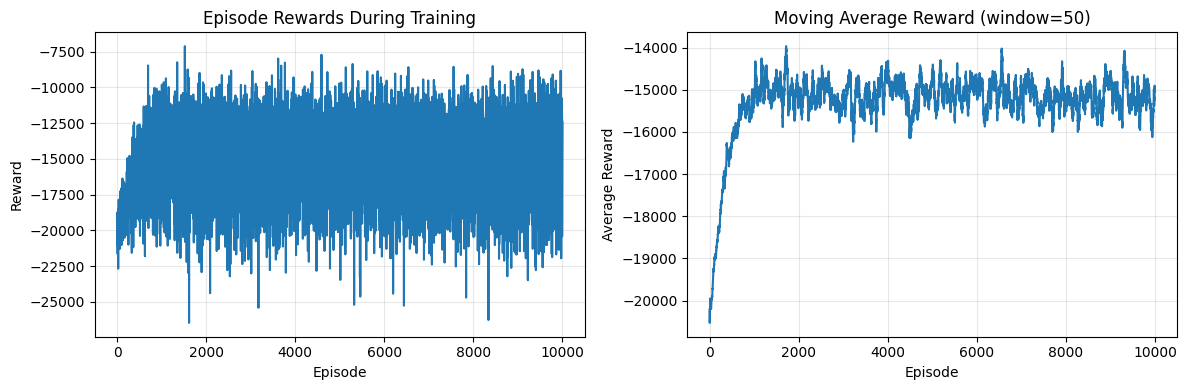


Evaluating trained agent...
Cumulative Profit - Mean: -15270.26, Std: 2572.13, Max: -9841.80, Min: -24243.00


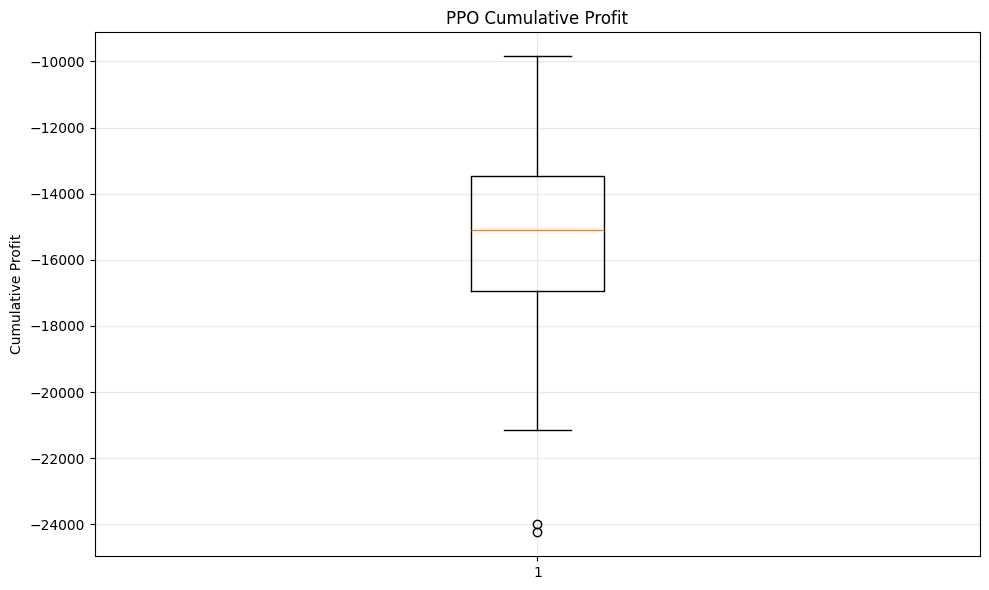

In [ ]:
# Create environment
env = create_gym_env()

# Train PPO agent
print("Training PPO agent...")
agent, episode_rewards = train_ppo(env, episodes=1000)

# Plot training progress
plot_training_progress(episode_rewards)

# Evaluate trained agent
print("\nEvaluating trained agent...")
cumulative_profits = calculate_cum_profit(agent, env, num_episodes=200)

# Visualize results
visualize_cum_profit(cumulative_profits)

# Final state

In [36]:
def show_final_state(env, agent):
    """Show final state after one episode"""
    state = reset_gym_env(env)
    total_reward = 0
    last_production = None
    
    for _ in range(25):
        action, _, _ = get_action(agent, state)
        action = np.clip(action, env['action_space']['low'], env['action_space']['high'])
        
        # Extract production from action
        product_types = env['supply_chain']['product_types_num']
        last_production = action[:product_types].astype(np.int32)
        
        state, reward, done, _ = step_gym_env(env, action)
        total_reward += reward
        if done: break
    
    final = env['state']
    print(f"Episode Reward: {total_reward:.1f}")
    print(f"Last Production: {last_production}")
    print(f"Factory Stocks: {final['factory_stocks']}")
    print(f"Warehouse Stocks:\n{final['distr_warehouses_stocks']}")

show_final_state(env, agent)

Episode Reward: -13118.0
Last Production: [0 0]
Factory Stocks: [-15   4]
Warehouse Stocks:
[[-44 -73]
 [-14 -82]]
